# Random Forest Classifier 
* Grid search to find best parameters
* Cross validation
* Parameter-CV accuary plotting

In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
import src.Utils as utils
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
import sklearn.ensemble as ske

# environment settings
data_path = 'Data/'

#hack to avoid showing deprecationg warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Deserialize previously saved data from "preprocessing"
with open(data_path+'train_pp.obj', 'rb') as train_pp, \
open(data_path+'test_pp.obj', 'rb') as test_pp:
    train_df = pickle.load(train_pp)
    test_df = pickle.load(test_pp)

In [30]:
#Separate training set from target variables
X,y = utils.train_test_separator(train_df)
#Create training set and test set with split 0.2
X_train , X_test ,y_train,y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=y)

In [32]:
# Grid search to find best parameter values
param_grid = {'n_estimators':[10,20,50,100,500],'max_features':[5,6,7],'max_depth':[5,7,9]}
grid_rf = GridSearchCV(ske.RandomForestClassifier(n_jobs=-1,criterion='entropy'),param_grid=param_grid,cv=10,scoring='accuracy')
grid_rf.fit(X,y)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.8451178451178452
{'max_depth': 5, 'max_features': 6, 'n_estimators': 50}


In [33]:
#Kfold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X,y)

#Initialization of Random Forest Classifier
rf = ske.RandomForestClassifier(n_estimators=50,
                                criterion='entropy',
                                max_depth = 5,
                                max_features = 6,
                                bootstrap=True)

#Cross-validation score saved in scores array
scores= []
for k,(train,test) in enumerate(kfold):
    rf.fit(X[train], y[train])
    rf_train_score = rf.score(X[test],y[test])
    scores.append(rf_train_score)
print("\nCV accuracy : {} +/- {}".format(np.mean(scores),np.std(scores)))
rf.fit(X_train,y_train)
rf_test_score=rf.score(X_test,y_test)
print("Random Forest test accuracies {}".format(rf_test_score))


CV accuracy : 0.8384610146407899 +/- 0.043265710531969905
Random Forest test accuracies 0.835820895522388


/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


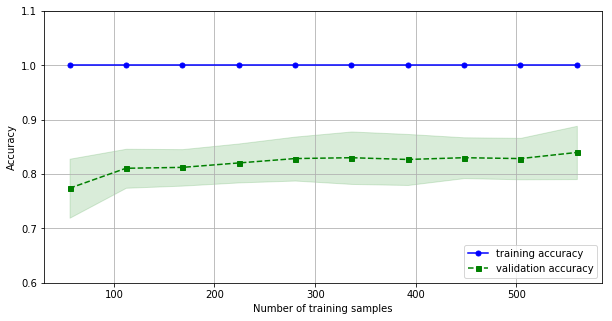

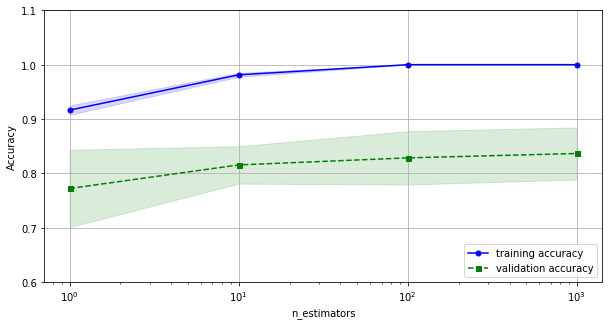

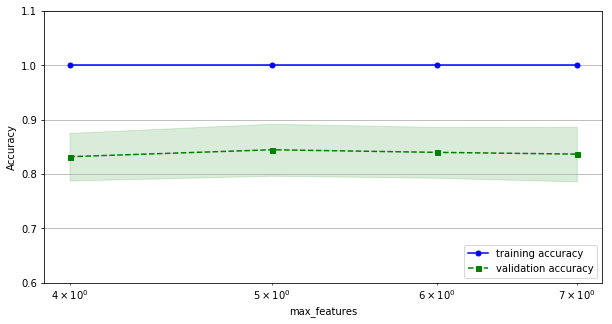

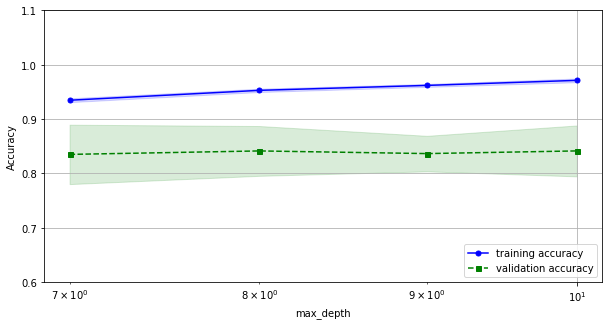

In [18]:
#Plotting graphs
plot_params = {
    'classifier': rf,
    'X_train': X_train,
    'y_train': y_train
}

utils.plot_cv_accuracy(**plot_params)
utils.plot_cv_parameters(**plot_params,
                        param='n_estimators',
                        param_range=[1,10,100,1000])
utils.plot_cv_parameters(**plot_params,
                         param='max_features',
                         param_range=[4,5,6,7])
utils.plot_cv_parameters(**plot_params,
                         param='max_depth',
                         param_range=[7,8,9,10])

#The graphs show grafically what the grid search found.

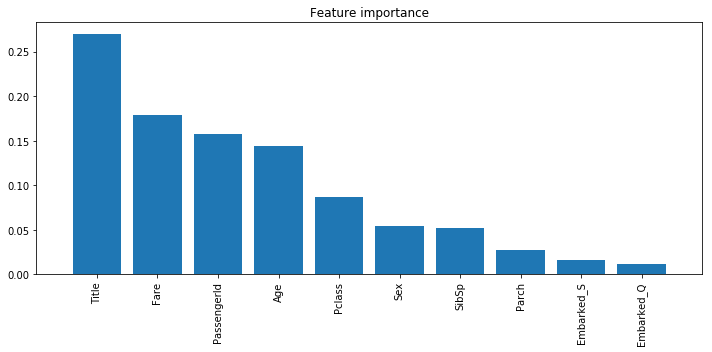

In [24]:
train_copy = train_df.drop(['Survived'], axis=1)
feat_labels = train_copy.columns[0:]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# for f in range(X.shape[1]):
#     print("%2d %-*s %f" %(f+1,30,feat_labels[indices[f]],importances[indices[f]]))

plot_params = {
    'X': X_train,
    'importances': importances,
    'indices' : indices,
    'feat_labels':feat_labels[indices]
}
utils.plot_feature_importance(**plot_params)

In [34]:
#Prediction on real test set using random forest
rf.fit(X,y)
survival_results =rf.predict(test_df)
result_df = pd.DataFrame(data={'PassengerId': test_df['PassengerId'].values,
                               'Survived': survival_results})
result_df['Survived'] = [0 if x == False else 1 for x in result_df['Survived']]
#Create output csv file
result_df.to_csv(data_path+"outputs/randomforest_ne_50_max_depth_5_max_features_6.csv", index=False)

In [7]:
#TODO :automatic file naming with param values , serialize output for ensamble learning, create plot for feature importancs